# Stellar Population Synthesis Utilities

Some basic functionality for analyzing `msaexp` spectra with population synthesis models

In [1]:
import os
import time

import numpy as np
import matplotlib.pyplot as plt

import msaexp.spectrum
import msaexp.resample_numba
import msaexp.utils
from msaexp.resample_numba import (
    resample_template_numba, compute_igm, calzetti2000_alambda, smc_alambda, salim_alambda, salim2018_fit_alambda
)

import grizli
import grizli.jwst_utils
from grizli import utils

import bagpipes

utils.set_warnings()
grizli.jwst_utils.set_quiet_logging()

print(time.ctime() + '\n------------------------')
for module in [msaexp, grizli]:
    print(f'{module.__name__}: {module.__version__}')
    

Thu Jun  6 16:54:00 2024
------------------------
msaexp: 0.8.5.dev12+g74df641
grizli: 1.11.9


## Read a spectrum

Read a DJA-reduced spectrum from the remote URL

/Users/gbrammer/miniconda3/envs/py310-bagpipes/lib/python3.10/site-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  arr.partition(


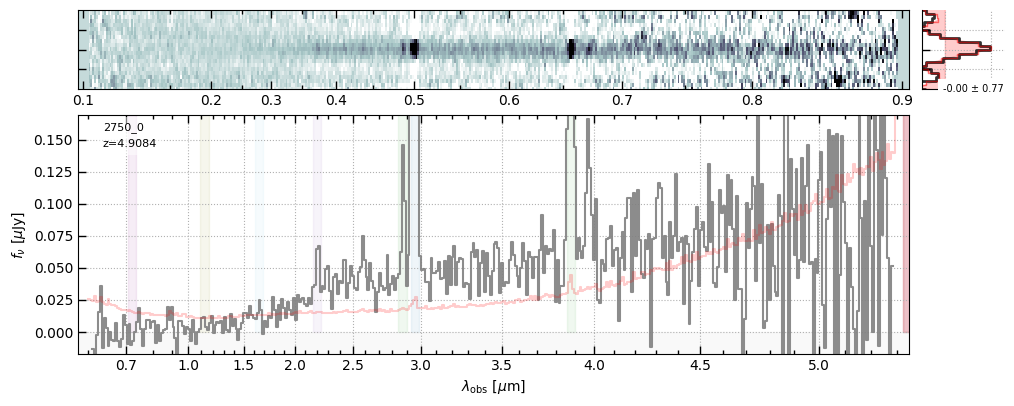

In [2]:
# CEERS-DDT z=16 / z=4 source (Arrabal-Haro et al.)
url = 'https://s3.amazonaws.com/msaexp-nirspec/extractions/ceers-ddt-v2/ceers-ddt-v2_prism-clear_2750_0.spec.fits'
z = 4.9084

spec = msaexp.spectrum.SpectrumSampler(url)
wobs = spec['wave'].astype(float)

fig = spec.drizzled_hdu_figure(z=z)

## General utilities

### Spectrum resampling

[msaexp.resample_numba.resample_template_numba](https://github.com/gbrammer/msaexp/blob/86520570596344e4f0ca0e54ca342e6a2ee71f6a/msaexp/resample_numba.py#L136) resamples a high resolution template to a low-resolution wavelength grid.  The resolution at each observed wavelength $\lambda$ is

$\sigma_\lambda^2 = \lambda^2~\left[ \left(\sigma_v / c\right)^2 + \left(2.35 \cdot R^\prime_\lambda\right)^{-2} \right]$,

where $R^\prime_\lambda = f \cdot R_\lambda$ is the tabulated grating resolution FWHM times some scale factor.

The resampling is demonstrated below using an arbitrarily redshifted high-resolution Solar spectrum from `calspec`.

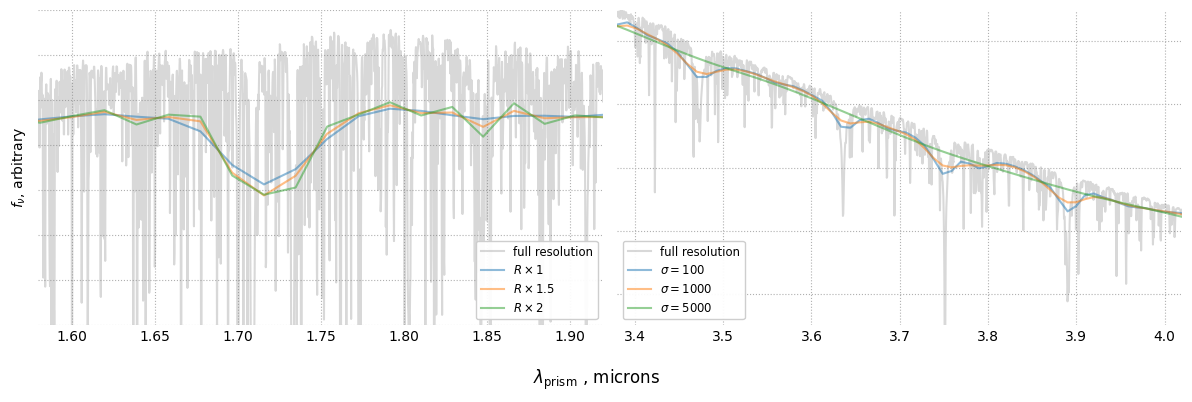

In [3]:
sun_spectrum = utils.read_catalog("https://archive.stsci.edu/hlsps/reference-atlases/cdbs/current_calspec/sun_mod_001.fits")

fig, axes = plt.subplots(1, 2, figsize=(12,4), gridspec_kw={'width_ratios':[1, 1]}, sharey=False)

# plot in Fnu
wnorm = 3.

z_dummy = 1

for ax in axes:
    ax.plot(sun_spectrum["WAVELENGTH"] / 1e4 * (1 + z_dummy),
            sun_spectrum["FLUX"] * (sun_spectrum["WAVELENGTH"] / 1e4 / wnorm * (1 + z_dummy))**2,
            color='0.5', alpha=0.3, label='full resolution')

    ax.grid()

ax = axes[0]

for scale_disp in [1, 1.5, 2]:
    resamp = resample_template_numba(
        wobs*1.e4,
        spec["R"] * scale_disp,
        sun_spectrum["WAVELENGTH"].astype(float) * (1 + z_dummy),
        sun_spectrum["FLUX"].astype(float),
        velocity_sigma=100,
    )
    
    ax.plot(spec["wave"],
            resamp * (spec["wave"] / wnorm)**2,
            label = r'$R \times$' + f'{scale_disp}',
            alpha=0.5,
           )

ax = axes[1]

for velocity_sigma in [100, 1000, 5000]:
    resamp = resample_template_numba(
        wobs*1.e4,
        spec["R"] * 1,
        sun_spectrum["WAVELENGTH"].astype(float) * (1 + z_dummy),
        sun_spectrum["FLUX"].astype(float),
        velocity_sigma=velocity_sigma,
    )
    
    ax.plot(spec["wave"],
            resamp * (spec["wave"] / wnorm)**2,
            label = r'$\sigma = $' + f'{velocity_sigma}',
            alpha=0.5,
           )

split = 1.31
split = 3.1
# split = 2.91
axes[0].set_xlim(0.55, split)
axes[1].set_xlim(split, 5.4)

axes[0].set_xlim(1.58, 1.92)
axes[0].set_ylim(30, 33.5)

axes[1].set_xlim(3.38, 4.02)
axes[1].set_ylim(17, 27)

axes[0].spines.right.set_visible(False)
axes[1].spines.left.set_visible(False)
axes[1].yaxis.set_ticks_position('none') 

for ax in axes:
    ax.spines.right.set_visible(False)
    ax.spines.left.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.spines.bottom.set_visible(False)
    ax.yaxis.set_ticks_position('none') 
    ax.xaxis.set_ticks_position('none') 
    ax.set_yticklabels([])
    
sp = axes[0].spines

leg = axes[0].legend(loc='lower right', framealpha=0.95)
leg = axes[1].legend(loc='lower left', framealpha=0.95)

fig.supxlabel(r'$\lambda_\mathrm{prism}~$, microns')
axes[0].set_ylabel(r'$f_\nu$, arbitrary')

fig.tight_layout(pad=1)

In [4]:
# time benchmark

print(f'high resolution: N={len(sun_spectrum)} wavelengths')
print(f'prism resolution: N={len(spec.spec)}')

wz = sun_spectrum["WAVELENGTH"].astype(float) * (1 + z_dummy)
fz = sun_spectrum["FLUX"].astype(float)
wa = wobs*1.e4
R = spec["R"]

# Takes a bit longer when you have to sample more wavelength points at higher v or lower R

for v in [100, 500, 5000]:
    print(f'\nvelocity_sigma = {v} km/s')
    %timeit resample_template_numba(wa, R, wz, fz, velocity_sigma=v)

# scale_disp > 1 means higher resolution
for scale_disp in [2, 1.5, 1]:
    print(f'\nscale_disp = {scale_disp}')
    Ri = R * scale_disp
    %timeit resample_template_numba(wa, Ri, wz, fz, velocity_sigma=100)
    

high resolution: N=74519 wavelengths
prism resolution: N=435

velocity_sigma = 100 km/s
2.4 ms ± 12.2 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)

velocity_sigma = 500 km/s
2.58 ms ± 25.1 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)

velocity_sigma = 5000 km/s
8.2 ms ± 46.8 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)

scale_disp = 2
1.27 ms ± 2.75 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)

scale_disp = 1.5
1.64 ms ± 4.82 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)

scale_disp = 1
2.41 ms ± 33 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### IGM transmission

[Inoue+ (2014)](https://ui.adsabs.harvard.edu/abs/2014MNRAS.442.1805I) transmission model.

In [5]:
igmz = compute_igm(z, wobs*1.e4)

# It's fast with the numba acceleration!
%timeit igmz = compute_igm(z, wobs*1.e4)

44.5 μs ± 199 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


/Users/gbrammer/miniconda3/envs/py310-bagpipes/lib/python3.10/site-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  arr.partition(


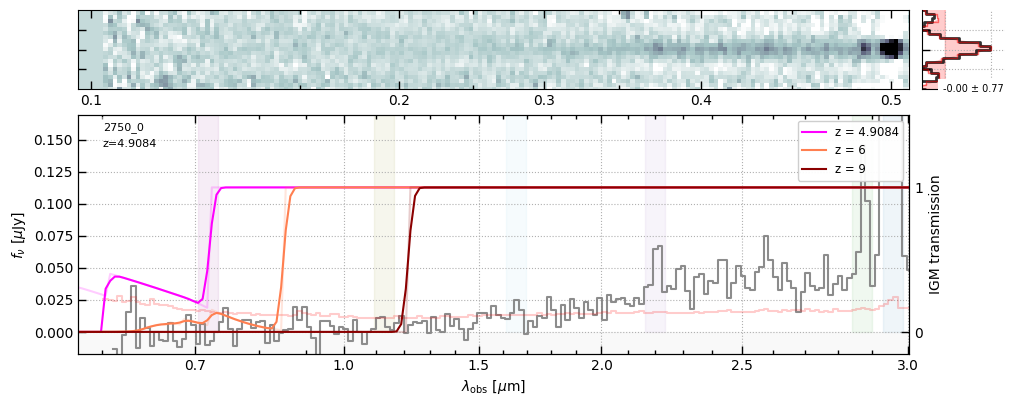

In [6]:
# IGM 
fig = spec.drizzled_hdu_figure(z=z)

ax = fig.axes[2]
ylim = ax.get_ylim()

a2 = ax.twinx()
ymax = 1.5
a2.set_ylim([ymax*ylim[0]/ylim[1], ymax])

a2.set_ylabel('IGM transmission')
a2.set_yticks([0,1])

wobs = spec['wave'].astype(float)

for zi, color in zip([z, 6, 9], ['magenta', 'coral', 'darkred']):
    igmz = compute_igm(zi, wobs*1.e4)

    # Account for spectral resolution
    igmz_sampled = resample_template_numba(wobs, spec['R'], wobs, igmz, velocity_sigma=0)
    
    a2.plot(igmz, color=color, alpha=0.2)
    a2.plot(igmz_sampled, label=f'z = {zi}', color=color)

for ax_i in [ax, a2, fig.axes[0]]:
    ax_i.set_xlim(0, 180)
    
leg = a2.legend(loc='upper right', framealpha=0.95)


### Dust attenuation

Adapt the Calzetti (2000), SMC (Gordon 2003), and Salim (2018) attenuation curves from the `bagpipes` implementation.


/Users/gbrammer/miniconda3/envs/py310-bagpipes/lib/python3.10/site-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  arr.partition(


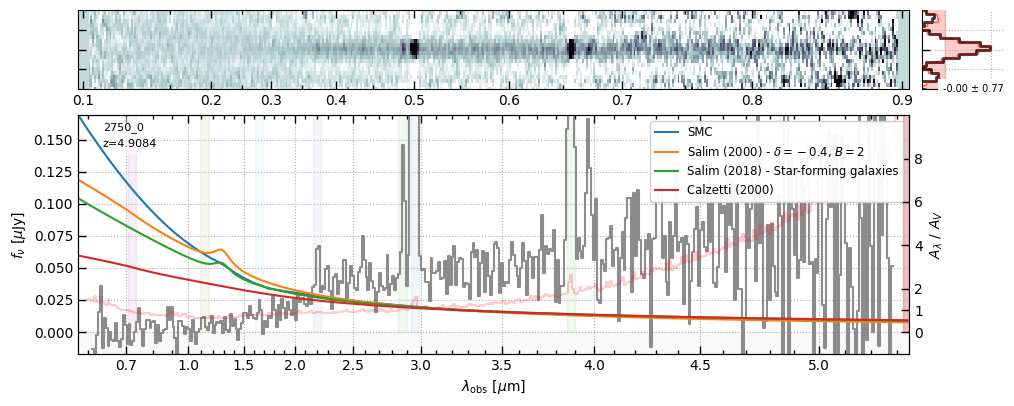

In [7]:
fig = spec.drizzled_hdu_figure(z=z)

ax = fig.axes[2]
ylim = ax.get_ylim()

a2 = ax.twinx()
a2.set_ylabel(r'$A_\lambda~/~A_V$')

ymax = 10
a2.set_ylim([ymax*ylim[0]/ylim[1], 10])

a2.set_yticks([0, 1, 2, 4, 6, 8])

alam = smc_alambda(wobs, z)
a2.plot(alam, label='SMC')

delta, B = -0.4, 2
alam = salim_alambda(wobs, z, delta, B)
a2.plot(alam, label=r'Salim (2000) - $\delta = xx$, $B = bb$'.replace('xx', f'{delta}').replace('bb', f'{B}'))

alam = salim2018_fit_alambda(wobs, z, 0)
a2.plot(alam, label='Salim (2018) - Star-forming galaxies')

alam = calzetti2000_alambda(wobs, z)
a2.plot(alam, label='Calzetti (2000)')
    
leg = a2.legend(loc='upper right', framealpha=0.95)


In [8]:
# Also very fast
print('SMC')
%timeit alam = smc_alambda(wobs, z)
print('Calzetti')
%timeit alam = calzetti2000_alambda(wobs, z)


SMC
2.43 μs ± 15 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
Calzetti
2.02 μs ± 12.3 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


## Bagpipes model

In [9]:
model_components = {}
model_components["redshift"] = z     # Observed redshift
model_components["t_bc"] = 0.01      # Max age of birth clouds: Gyr
model_components["veldisp"] = 100    # Velocity dispersion: km/s

constant = {}                        # tophat function
constant["age_max"] = 0.1            # Time since SF switched on: Gyr
constant["age_min"] = 0.0            # Time since SF switched off: Gyr
constant["massformed"] = 9           # Log_10 total stellar mass formed: M_Solar
constant["metallicity"] = 0.5        # Metallicity: Z_sol = 0.02

model_components["constant"] = constant   # Dict containing SFH info

nebular = {}
nebular["logU"] = -2.5               # Log_10 of the ionization parameter.

## Dust
dust = {}
dust["type"] = "Calzetti"  # Attenuation law: "Calzetti", "Cardelli", "CF00" or "Salim"
dust["Av"] = 4.0           # Absolute attenuation in the V band: magnitudes
dust["eta"] = 1.           # Multiplicative factor on Av for stars in birth clouds

# Dust emission parameters
dust["qpah"] = 2.          # PAH mass fraction
dust["umin"] = 1.          # Lower limit of starlight intensity distribution
dust["gamma"] = 0.01       # Fraction of stars at umin

model_components["dust"] = dust
model_components["nebular"] = nebular

model_components["R_curve"] = np.c_[spec["wave"]*1.e4, spec["R"]]

# Initialize the model
model = bagpipes.model_galaxy(model_components,
                              spec_wavs=spec["wave"]*1.e4,
                              spec_units="mujy",
                             )

### Compare the resampling functions

`bagpipes.model_galaxy.update()` updates the parameters and resamples the spectrum using the tabulated resolution curve, if available. 

With the timing tests below, updating the model including the resampling takes 16.9 ms with the resampling, and 5.6 ms without it, so the spectrum resampling is the rate-limiting action (16.9 - 5.6 = 11.3 ms) when calling the function many times, e.g., when sampling the likelihood.  The `numba`-accelerated MSAEXP resampling method, however, is almost  *~40x faster*, taking just 291 μs per call (these numbers might change slightly depending on the system and cpu activity).

In [10]:
print("Bagpipes resamples the spectrum")
%timeit model.update(model_components)
pipes_resampled = model.spectrum*1

# Reset spec_wavs so that bagpipes doesn't do the resample, which will be done with msaexp
print("\nBagpipes just updates spectrum_full")
model.spec_wavs = None
%timeit model.update(model_components)

# Time the MSAEXP resample function
print("\nMSAEXP resample")
%timeit msaexp_resampled = spec.resample_bagpipes_model(model, model_components, scale_disp=1.0)

Bagpipes resamples the spectrum
17.3 ms ± 315 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Bagpipes just updates spectrum_full
5.68 ms ± 48.7 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)

MSAEXP resample
628 μs ± 43 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Show the models

Do a quick comparison of the models with different dust $A_V$, though none is a particularly good representation of the spectrum because the model has not been optimized in any way (e.g., SFH, $Z$, etc.).

In the example, compute a normalization factor to scale the model to the spectrum with simple least-squares weighted by the inverse variance spectrum.  The "best fit" stellar mass is calculated from the `massformed` model parameter scaled by this factor.

/Users/gbrammer/miniconda3/envs/py310-bagpipes/lib/python3.10/site-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  arr.partition(


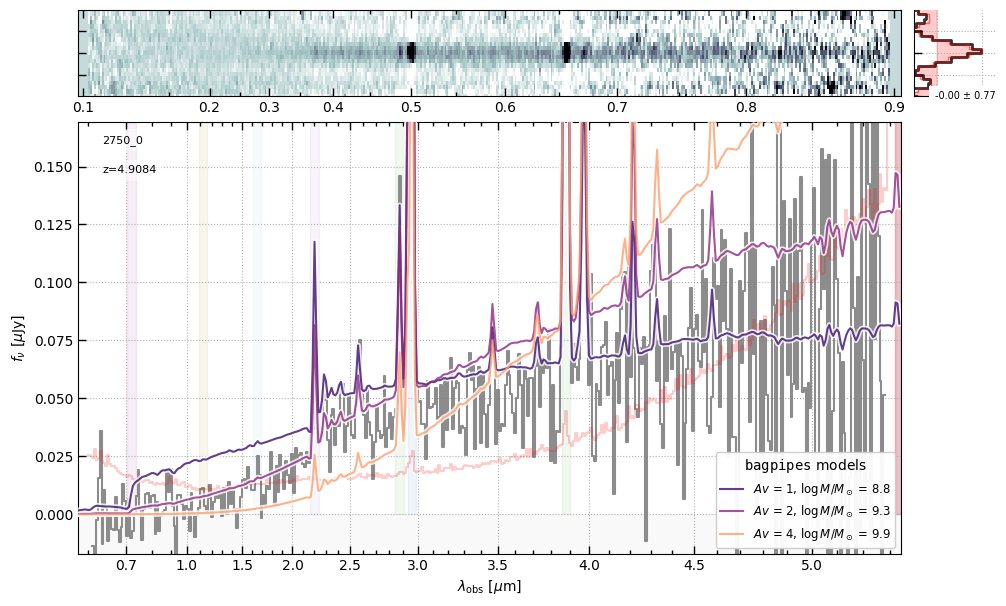

In [11]:
subplot_args={'figsize': (10, 6), 'height_ratios': [1, 5], 'width_ratios': [10, 1]}

fig = spec.drizzled_hdu_figure(z=z, subplot_args=subplot_args)

ax = fig.axes[2]

for Av in [1, 2, 4]:
    model_components["dust"]["Av"] = Av
    model.update(model_components)
    msaexp_model = spec.resample_bagpipes_model(model, model_components, scale_disp=1.3)

    # Simple lsq normalization
    norm = (spec["flux"] * msaexp_model / spec["full_err"]**2)[spec["valid"]].sum()
    norm /= (msaexp_model**2 / spec["full_err"]**2)[spec["valid"]].sum()
    logm = 9 + np.log10(norm)
    
    ax.plot(msaexp_model * norm, color='w', lw=4, zorder=10, alpha=0.8)
    ax.plot(msaexp_model * norm, color=plt.cm.magma(Av / 5.),
            alpha=0.8,
            zorder=12,
            label=r'$Av$ = ' + f'{Av}' + r', $\log M/M_\odot$ = ' + f'{logm:.1f}')

leg = ax.legend(loc='lower right', framealpha=0.95)
leg.set_zorder(10000)
leg.set_title(r"$\mathtt{bagpipes}$ models")
    

# Automatic handling of different gratings

The `msaexp.spectrum.SpectrumSampler` class automatically populates the resolution curve as necessary for the grating that was used.


/Users/gbrammer/miniconda3/envs/py310-bagpipes/lib/python3.10/site-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  arr.partition(


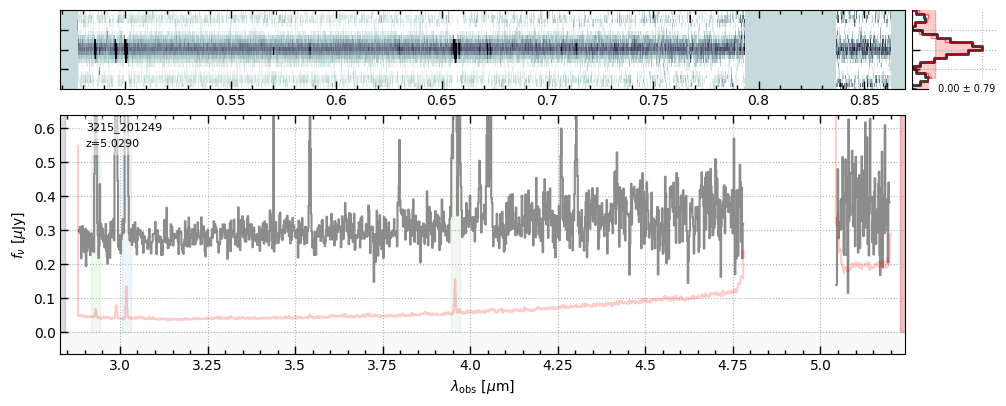

In [12]:
# From GO-3215
url = 'https://s3.amazonaws.com/msaexp-nirspec/extractions/gds-udeep-v2/gds-udeep-v2_g395m-f290lp_3215_201249.spec.fits'
z = 5.029

spec = msaexp.spectrum.SpectrumSampler(url)
wobs = spec['wave'].astype(float)

fig = spec.drizzled_hdu_figure(z=z)

In [13]:
# This is optional, but don't need the R_curve in `model_components` if you're using the MSAEXP sampler
# because it's read from `spec['R']` in `spec.resample_bagpipes_model`
if "R_curve" in model_components:
    _ = model_components.pop("R_curve")

model = bagpipes.model_galaxy(model_components,
                              spec_wavs=spec["wave"]*1.e4,
                              spec_units="mujy",
                             )
model.spec_wavs = None

/Users/gbrammer/miniconda3/envs/py310-bagpipes/lib/python3.10/site-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  arr.partition(


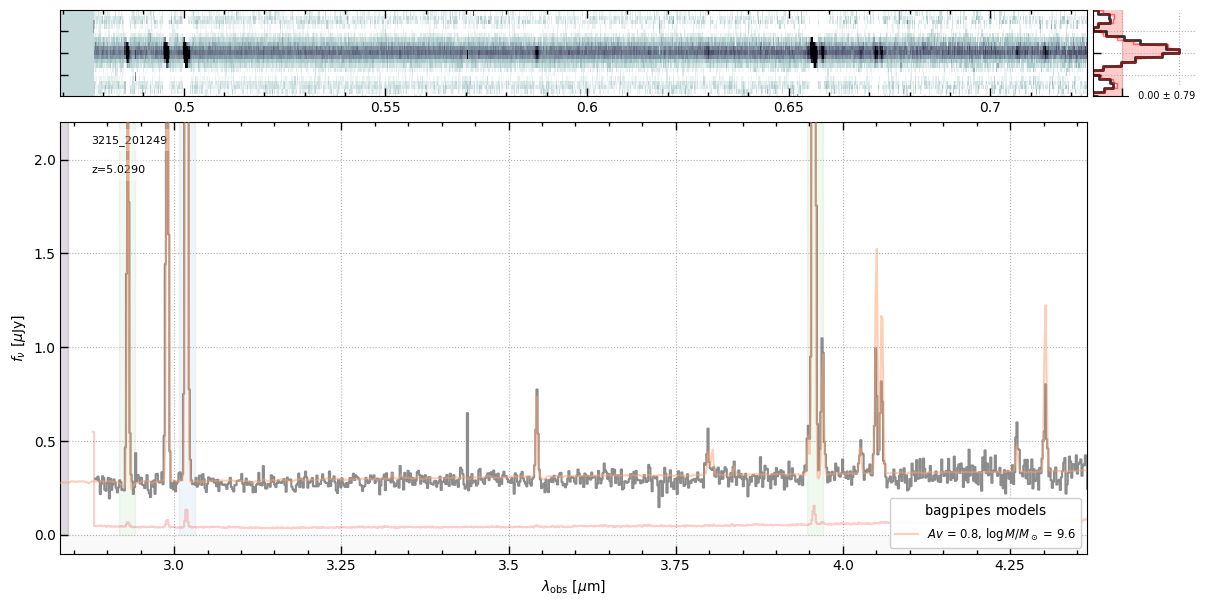

In [14]:
subplot_args={'figsize': (12, 6), 'height_ratios': [1, 5], 'width_ratios': [10, 1]}

fig = spec.drizzled_hdu_figure(z=z, subplot_args=subplot_args)

model_components["redshift"] = z
model_components["veldisp"] = 100
model_components["constant"]["age_max"] = 0.2
model_components["constant"]["metallicity"] = 0.3
Av = 0.8
model_components["dust"]["Av"] = Av

ax = fig.axes[2]

model_components["dust"]["Av"] = Av
model.update(model_components)
msaexp_model = spec.resample_bagpipes_model(model, model_components, scale_disp=1.8)

# Simple lsq normalization
norm = (spec["flux"] * msaexp_model / spec["full_err"]**2)[spec["valid"]].sum()
norm /= (msaexp_model**2 / spec["full_err"]**2)[spec["valid"]].sum()
logm = 9 + np.log10(norm)

# ax.plot(msaexp_model * norm, color='w', lw=4, zorder=10, alpha=0.8)
ax.plot(msaexp_model * norm, color=plt.cm.magma(Av / 1.),
        alpha=0.5,
        zorder=12,
        label=r'$Av$ = ' + f'{Av}' + r', $\log M/M_\odot$ = ' + f'{logm:.1f}')

leg = ax.legend(loc='lower right', framealpha=0.95)
leg.set_zorder(10000)
leg.set_title(r"$\mathtt{bagpipes}$ models")

ax.set_ylim(-0.1, 2.2)
for ax_i in [ax, fig.axes[0]]:
    ax_i.set_xlim(0, 900)

# ax.set_xlim(600, 800)
# ax.set_ylim(0., 2.5)


In [15]:
# Not much slower per call than for the prism
%timeit msaexp_model = spec.resample_bagpipes_model(model, model_components, scale_disp=1.8)

349 μs ± 1.66 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
